# Derivation and Benchmarking of Custom Numerical Integration Functions
*September 19th 2021*

**Aim - Benchmark different numerical integration functions are choose the best implementation to use in autoRS.core.utils**

Ideally, we can just import scipy.integrate.cumulative_trapezoidal. However, scipy is a very large library that would make the .exe file made with pyinstaller unnecessarily big. So, we can implement a custom integration functions in autoRS.core.utils.
- Implement cumulative Simpson's rule integration function. 
- Compare results to numpy.cumulative_trapezoidal
- Compare against theoretical solutions.

In [1]:
# Standard library imports
import os
import sys
from itertools import product, accumulate
from time import perf_counter
from typing import Optional

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import cumtrapz, simps

# Add project root to path
pkg_path = os.path.abspath("..")
if pkg_path not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))

# Local application imports
import autoRS

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Derive Simpson's 1/3 and 3/8 rules

- Simpson's 1/3 rule assumes a quadratic function between 3 equally spaced points.
    - I.e. consider 3 consecutive points, $(x_1, y_1)$, $(x_2, y_2)$, $(x_3, y_3)$.
    - $x_2 - x_1 = h$, $x_3 - x_2 = h$
    - Using the fact that the points are equally-spaced, the points become: $(0, y_1)$, $(h, y_2)$, $(2h, y_3)$.
    - The 1/3 rule is derived by assuming the function: $y = Ax^2 + Bx + C$.
    - $A$, $B$, $C$ can be calculated by solving the 3 simultaneous equations obtained from substituting the 3 points into the quadratic function.
    - The integral of the function can then be calculated from $x_1$ to $x_2$, $x_2$ to $x_3$, or $x_1$ to $x_3$. The integral will be in terms of $h$, $y_1$, $y_2$, and $y_3$.


- Simpson's 3/8 rule assumes a cubic function between 4 equally spaced points.
    - I.e. consider 4 consecutive points, $(x_1, y_1)$, $(x_2, y_2)$, $(x_3, y_3)$, $(x_4, y_4)$.
    - $x_2 - x_1 = h$, $x_3 - x_2 = h$, $x_4 - x_3 = h$
    - Using the fact that the points are equally-spaced, the points become: $(0, y_1)$, $(h, y_2)$, $(2h, y_3)$, $(3h, y_4)$.
    - The 3/8 rule is derived by assuming the function: $y = Ax^3 + Bx^2 + Cx + D$.
    - $A$, $B$, $C$, $D$ can be calculated by solving the 4 simultaneous equations obtained from substituting the 4 points into the cubic function.
    - The integral of the function can then be calculated from $x_1$ to $x_2$, $x_2$ to $x_3$, $x_3$ to $x_4$, or $x_1$ to $x_4$. The integral will be in terms of $h$, $y_1$, $y_2$, $y_3$, and $y_4$.

The derived integral equations can be used in the numerical integration schemes.

In [453]:
from sympy import symbols, solve, collect, simplify, integrate, Eq, Integral
from sympy.abc import A, B, C, D, x, y

h, x1, x2, x3, x4, y1, y2, y3, y4 = symbols("h, x1, x2, x3, x4, y1, y2, y3, y4")

In [436]:
# Simultaneous equations for Simpsons 1/3 rule
poly_eqns = [
    A*0**2 + B*0 + C - y1,
    A*h**2 + B*h + C - y2,
    A*(2*h)**2 + B*(2*h) + C - y3,
]

# Simultaneous equations for Simpsons 3/8 rule
cubic_eqns = [
    A*0**3 + B*0**2 + C*0 + D - y1,
    A*h**3 + B*h**2 + C*h + D - y2,
    A*(2*h)**3 + B*(2*h)**2 + C*(2*h) + D - y3,
    A*(3*h)**3 + B*(3*h)**2 + C*(3*h) + D - y4,
]

In [438]:
poly_res = solve(eqns, (A, B, C), dict=True)[0]
cubic_res = solve(eqns2, (A, B, C, D), dict=True)[0]

In [448]:
print("Simpson's 1/3 rule solutions")
for key, value in poly_res.items():
    display(Eq(key, value))

Simpson's 1/3 rule solutions


Eq(A, (y1 - 2*y2 + y3)/(2*h**2))

Eq(B, (-3*y1 + 4*y2 - y3)/(2*h))

Eq(C, y1)

In [465]:
print("Equations to calculate Simpson's 1/3 rule integrals")
int1 = integrate(res[A]*x**2 + res[B]*x + res[C], (x, 0, 2*h))
int2 = integrate(res[A]*x**2 + res[B]*x + res[C], (x, 0, h))
int3 = integrate(res[A]*x**2 + res[B]*x + res[C], (x, h, 2*h))
display(Eq(Integral(y, (x, 0, 2*h)), collect(int1, h)))
display(Eq(Integral(y, (x, 0, h)), collect(int2, h)))
display(Eq(Integral(y, (x, h, 2*h)), collect(int3, h)))

Equations to calculate Simpson's 1/3 rule integrals


Eq(Integral(y, (x, 0, 2*h)), h*(y1/3 + 4*y2/3 + y3/3))

Eq(Integral(y, (x, 0, h)), h*(5*y1/12 + 2*y2/3 - y3/12))

Eq(Integral(y, (x, h, 2*h)), h*(-y1/12 + 2*y2/3 + 5*y3/12))

In [449]:
print("Simpson's 3/8 rule solutions")
for key, value in cubic_res.items():
    display(Eq(key, value))

Simpson's 3/8 rule solutions


Eq(A, (-y1 + 3*y2 - 3*y3 + y4)/(6*h**3))

Eq(B, (2*y1 - 5*y2 + 4*y3 - y4)/(2*h**2))

Eq(C, (-11*y1 + 18*y2 - 9*y3 + 2*y4)/(6*h))

Eq(D, y1)

In [469]:
print("Equations to calculate Simpson's 3/8 rule integrals")
int_cubic1 = integrate(res2[A]*x**3 + res2[B]*x**2 + res2[C]*x + res2[D], (x, 0, 3*h))
int_cubic2 = integrate(res2[A]*x**3 + res2[B]*x**2 + res2[C]*x + res2[D], (x, 0, h))
int_cubic3 = integrate(res2[A]*x**3 + res2[B]*x**2 + res2[C]*x + res2[D], (x, h, 2*h))
int_cubic4 = integrate(res2[A]*x**3 + res2[B]*x**2 + res2[C]*x + res2[D], (x, 2*h, 3*h))

display(Eq(Integral(y, (x, 0, 3*h)), collect(int_cubic1, h)))
display(Eq(Integral(y, (x, 0, h)), collect(int_cubic2, h)))
display(Eq(Integral(y, (x, h, 2*h)), collect(int_cubic3, h)))
display(Eq(Integral(y, (x, 2*h, 3*h)), collect(int_cubic4, h)))

Equations to calculate Simpson's 3/8 rule integrals


Eq(Integral(y, (x, 0, 3*h)), h*(3*y1/8 + 9*y2/8 + 9*y3/8 + 3*y4/8))

Eq(Integral(y, (x, 0, h)), h*(3*y1/8 + 19*y2/24 - 5*y3/24 + y4/24))

Eq(Integral(y, (x, h, 2*h)), h*(-y1/24 + 13*y2/24 + 13*y3/24 - y4/24))

Eq(Integral(y, (x, 2*h, 3*h)), h*(y1/24 - 5*y2/24 + 19*y3/24 + 3*y4/8))

## Define cumulative integration functions

In [572]:
def cumulative_trapezoidal(
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, 
    initial: Optional[float] = 0,
) -> np.ndarray:
    """Trapezoidal integration of samples."""
    y = np.asarray(y)
    if x is not None:
        x = np.asarray(x)
    else:
        x = np.arange(0, dx*len(y), dx)
    
    sub_integrals = np.diff(x) * (y[:-1] + y[1:])/2
    
    return np.cumsum(np.concatenate(([initial], sub_integrals)))
    
    
def cumulative_integral_3(
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, 
    initial: Optional[float] = 0,
) -> np.ndarray:
    """1/3 composite simpson's rule"""
    y = np.asarray(y)
    if len(y) < 3:
        return cumulative_trapezoidal(y, x, dx, initial)
    if x is not None:
        x = np.asarray(x)
    else:
        x = np.arange(0, dx*len(y), dx)
#     res = [initial]
    
    # Trapezoidal rule for the first integration point
#     value = (x[1] - x[0]) * (y[1] + y[0])/2
#     res.append(res[-1] + value)
    
#     if len(y) == 2:
#         return np.asarray(res)
    
    # 1/3 Simpson's rule for all remaining value
#     sub_integrals = (x[2:] - x[:-2])/6 * (y[:-2] + 4*y[1:-1] + y[2:])
    
#     if len(y) == 3:
#         res.append(res[-2] + sub_integrals[0])
#         return np.asarray(res)
    
    # 3/8 simpson's rule for first 4 points --> used to improve accuracy of first point
#     simps8 = (x[3] - x[0])/8 * (y[0] + 3*y[1] + 3*y[2] + y[3])
#     res[1] = res[0] + simps8 - sub_integrals[1]
    
    
    sub_integrals_fwd = (x[2:] - x[:-2])/6 * (5*y[:-2]/4 + 2*y[1:-1] - y[2:]/4)
    sub_integrals_bwd = (x[2:] - x[:-2])/6 * (-y[:-2]/4 + 2*y[1:-1] + 5*y[2:]/4)
    
    sub_integrals = np.concatenate((
        [initial],
        [sub_integrals_fwd[0]],
        (sub_integrals_fwd[1:] + sub_integrals_bwd[:-1])/2,
        [sub_integrals_bwd[-1]],
    ))
    
    return np.cumsum(sub_integrals)

#     for value in sub_integrals:
#         res.append(res[-2] + value)
        
#     return np.asarray(res)


def cumulative_integral_8(
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, 
    initial: Optional[float] = 0,
) -> np.ndarray:
    """3/8 composite simpson's rule"""
    
    y = np.asarray(y)
    if len(y) < 4:
        return cumulative_integral_3(y, x, dx, initial)
    
    if x is not None:
        x = np.asarray(x)
    else:
        x = np.arange(0, dx*len(y), dx)
#     res = [initial]
    
    # Trapezoidal rule for the first integration point
#     trapz_value = (x[1] - x[0]) * (y[1] + y[0])/2
#     res.append(res[-1] + trapz_value)
    
#     if len(y) == 2:
#         return np.asarray(res)
    
    # 1/3 Simpson's rule for the second integration point
#     simps_value = (x[2] - x[0])/6 * (y[2] + 4*y[1] + y[0])
#     res.append(res[-2] + simps_value)
    
#     if len(y) == 3:
#         return np.asarray(res)
    
    # 3/8 Simpson's rule for all remaining points
#     sub_integrals = (x[3:] - x[:-3])/8 * (y[:-3] + 3*y[1:-2] + 3*y[2:-1] + y[3:])
    
    # 1/3 simpson's rule for points 1, 2, and 3
#     simps2 = (x[3] - x[1])/6 * (y[3] + 4*y[2] + y[1])
    
    # Correct first integration point from trapezoidal rule to 3/8 simpsons - 1/3 simpsons
#     res[1] = sub_integrals[0] - simps2 + res[0]
    
    sub_integrals_fwd = (x[3:] - x[:-3])/3 * (3*y[:-3]/8 + 19*y[1:-2]/24 - 5*y[2:-1]/24 + y[3:]/24)
    sub_integrals_mid = (x[3:] - x[:-3])/3 * (-y[:-3]/24 + 13*y[1:-2]/24 + 13*y[2:-1]/24 - y[3:]/24)
    sub_integrals_bwd = (x[3:] - x[:-3])/3 * (y[:-3]/24 - 5*y[1:-2]/24 + 19*y[2:-1]/24 + 3*y[3:]/8)
    
    sub_integrals = np.concatenate((
        [initial],
        [sub_integrals_fwd[0]],
        [(sub_integrals_fwd[1] + sub_integrals_mid[0])/2],
        (sub_integrals_fwd[2:] + sub_integrals_mid[1:-1] + sub_integrals_bwd[:-2])/3,
        [(sub_integrals_bwd[-2] + sub_integrals_mid[-1])/2],
        [sub_integrals_bwd[-1]],
    ))
    
    return np.cumsum(sub_integrals)

    # 3/8 simpson's rule accumulation
#     for value in sub_integrals:
#         res.append(res[-3] + value)
        
#     return np.asarray(res)

## Test Integration with Example Function

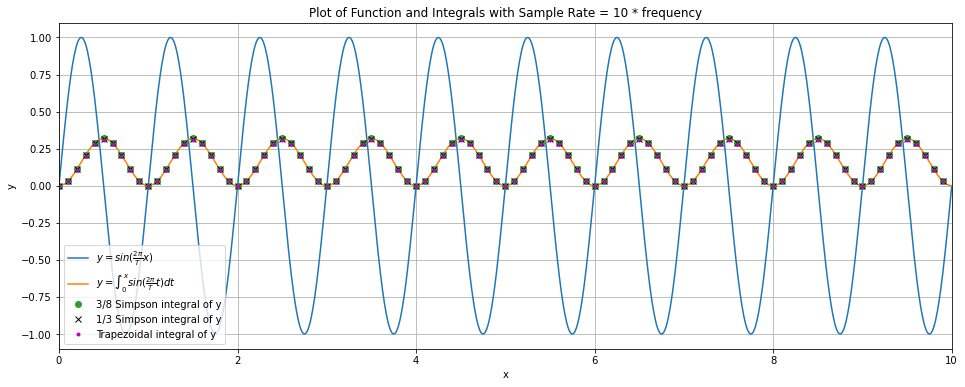

In [593]:
freq_y = 1
multiplier = 10
sample_freq_y = freq_y*multiplier
period_y = 1/freq_y
alpha = (2*np.pi/period_y)

t_max = 10
t = np.linspace(0, t_max, num=1000)
int_t = np.arange(0, t_max, 1/sample_freq_y)

def y(x):
    return np.sin(alpha*x)

def int_y(x):
    return (-np.cos(alpha*x) + 1)/alpha

simps_3_int_y = cumulative_integral_3(y(int_t), int_t, initial=0)
simps_8_int_y = cumulative_integral_8(y(int_t), int_t, initial=0)
trapz_int_y = cumtrapz(y(int_t), int_t, initial=0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t, y(t), label=r"$y=sin(\frac{2\pi}{T} x)$")
ax.plot(t, int_y(t), label=r"$y=\int_0^x{sin(\frac{2\pi}{T} t) dt}$")
ax.plot(int_t, simps_8_int_y, 'o', label="3/8 Simpson integral of y")
ax.plot(int_t, simps_3_int_y, 'kx', label="1/3 Simpson integral of y")
ax.plot(int_t, trapz_int_y, 'm.', label="Trapezoidal integral of y")
ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Function and Integrals with Sample Rate = {multiplier} * frequency")
ax.legend(loc="lower left")
ax.grid()

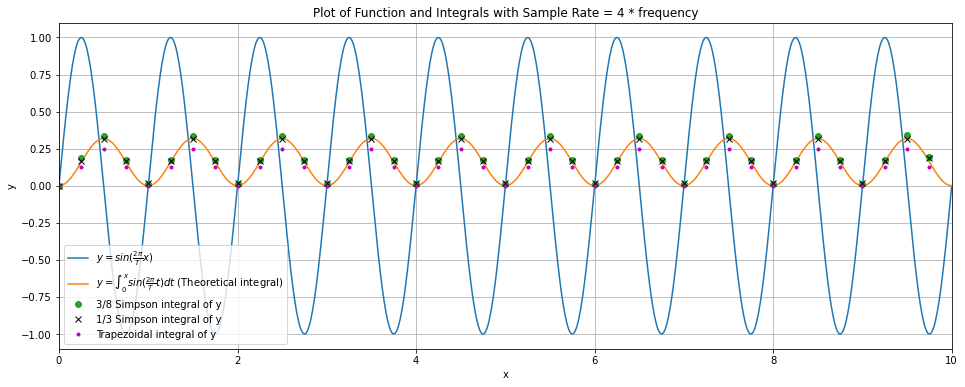

In [594]:
multiplier = 4
sample_freq_y = freq_y*multiplier
int_t = np.arange(0, t_max, 1/sample_freq_y)

simps_3_int_y = cumulative_integral_3(y(int_t), int_t, initial=0)
simps_8_int_y = cumulative_integral_8(y(int_t), int_t, initial=0)
trapz_int_y = cumtrapz(y(int_t), int_t, initial=0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t, y(t), label=r"$y=sin(\frac{2\pi}{T} x)$")
ax.plot(t, int_y(t), label=r"$y=\int_0^x{sin(\frac{2\pi}{T} t) dt}$ (Theoretical integral)")
ax.plot(int_t, simps_8_int_y, 'o', label="3/8 Simpson integral of y")
ax.plot(int_t, simps_3_int_y, 'kx', label="1/3 Simpson integral of y")
ax.plot(int_t, trapz_int_y, 'm.', label="Trapezoidal integral of y")
ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Function and Integrals with Sample Rate = {multiplier} * frequency")
ax.legend(loc="lower left")
ax.grid()

## Validate Implementations by Comparing with Scipy.integrate Functions

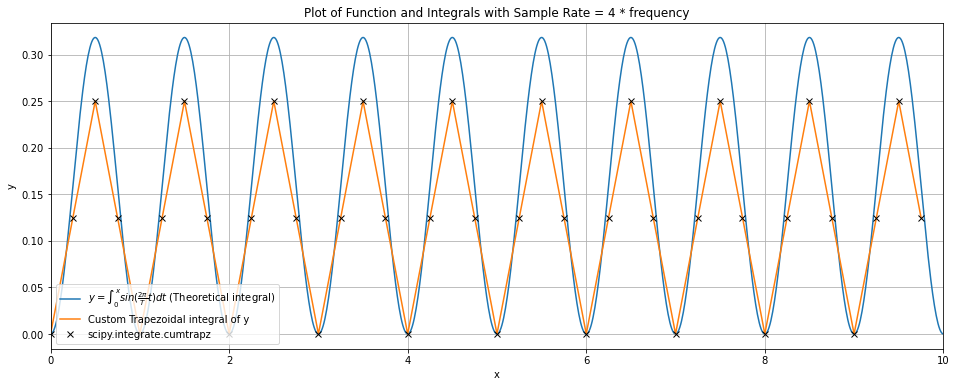

In [595]:
fig, ax = plt.subplots(figsize=(16, 6))
trapz_int_y = cumtrapz(y(int_t), int_t, initial=0)
custom_trapz_y = cumulative_trapezoidal(y(int_t), int_t, initial=0)

ax.plot(t, int_y(t), label=r"$y=\int_0^x{sin(\frac{2\pi}{T} t) dt}$ (Theoretical integral)")
ax.plot(int_t, custom_trapz_y, label="Custom Trapezoidal integral of y")
ax.plot(int_t, trapz_int_y, 'kx', label="scipy.integrate.cumtrapz")

ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Function and Integrals with Sample Rate = {multiplier} * frequency")
ax.legend(loc="lower left")
ax.grid()

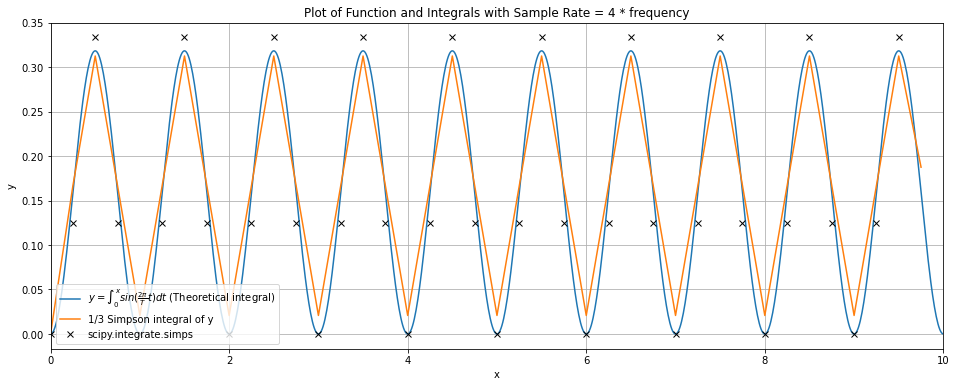

In [596]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t, int_y(t), label=r"$y=\int_0^x{sin(\frac{2\pi}{T} t) dt}$ (Theoretical integral)")
ax.plot(int_t, simps_3_int_y, label="1/3 Simpson integral of y")
act_simps = [simps(y(int_t[:i]), int_t[:i], even='last') for i in range(1, len(int_t))]
ax.plot(int_t[:-1], act_simps, 'kx', label="scipy.integrate.simps")

ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Function and Integrals with Sample Rate = {multiplier} * frequency")
ax.legend(loc="lower left")
ax.grid()

The black points match the orange line --> this validates the custom 1/3 rule simpson's implementation

## Quantify Errors

- Calculate the average error in the numerical integration over multiple sample rates.
- The example function has a period of 1s. Hence the sample rates can be though of as sample rate multipliers relative to the highest frequency of interest in a typical vibratory signal.
- Plot the average error for different numerical integration methods over the range of sample rates.
- Repeat test using an example function with multiple frequencies of motion.

In [609]:
sample_rate = np.linspace(2, 10, num=400)
int_range = max(int_y(t)) - min(int_y(t))

def get_mean_error(cum_int_func, sr, func=y, int_func=int_y):
    int_t = np.arange(0, t_max, 1/sr)
    int_range = max(int_func(int_t)) - min(int_func(int_t))
    res = cum_int_func(func(int_t), int_t, initial=0)
    error = np.mean(np.abs(int_func(int_t) - res))/int_range * 100
    return error

simps_3_error = [get_mean_error(cumulative_integral_3, sr)/int_range for sr in sample_rate]
simps_8_error = [get_mean_error(cumulative_integral_8, sr)/int_range for sr in sample_rate]
trapz_error = [get_mean_error(cumulative_trapezoidal, sr)/int_range for sr in sample_rate]

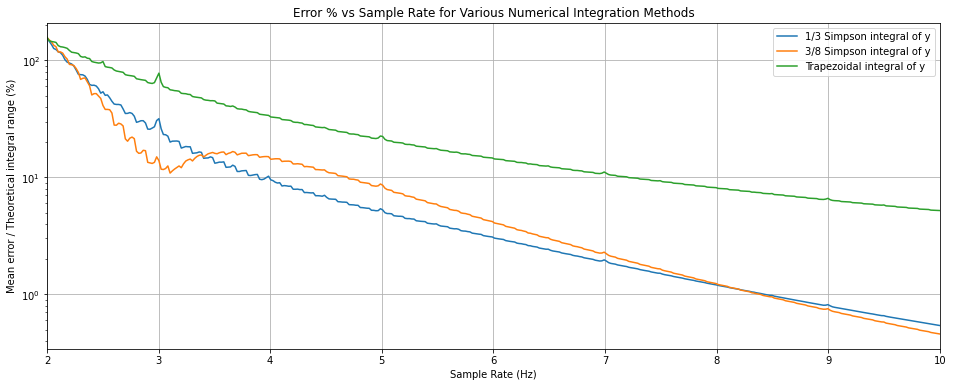

In [610]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.semilogy(sample_rate, simps_3_error, label="1/3 Simpson integral of y")
ax.semilogy(sample_rate, simps_8_error, label="3/8 Simpson integral of y")
ax.semilogy(sample_rate, trapz_error, label="Trapezoidal integral of y")
ax.grid()
ax.set(xlim=(min(sample_rate), max(sample_rate)), xlabel="Sample Rate (Hz)", 
       ylabel="Mean error / Theoretical integral range (%)", 
       title="Error % vs Sample Rate for Various Numerical Integration Methods")
ax.legend()

In [611]:
def y2(x):
    return np.sin(alpha*x) + 5*np.sin(alpha/5*x)

def int_y2(x):
    return (-np.cos(alpha*x) + 1)/alpha + 5*(-np.cos(alpha/5*x) + 1)/(alpha/5)

sample_rate = np.linspace(2, 35, num=500)
int_range = max(int_y2(t)) - min(int_y2(t))

simps_3_error2 = [get_mean_error(cumulative_integral_3, sr, y2, int_y2)/int_range for sr in sample_rate]
simps_8_error2 = [get_mean_error(cumulative_integral_8, sr, y2, int_y2)/int_range for sr in sample_rate]
trapz_error2 = [get_mean_error(cumulative_trapezoidal, sr, y2, int_y2)/int_range for sr in sample_rate]

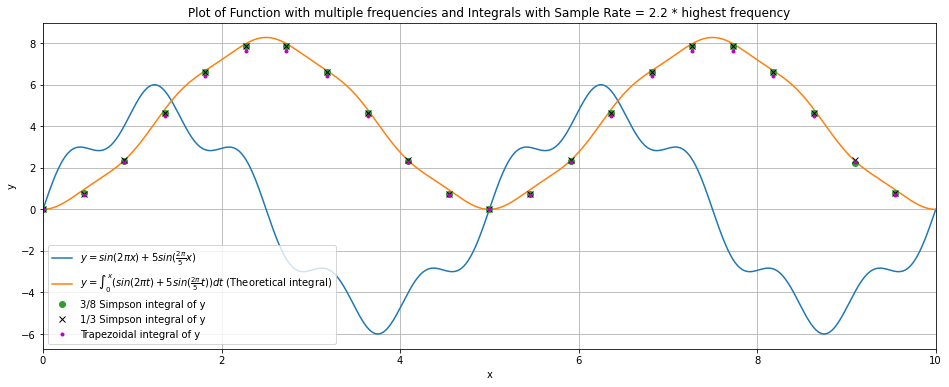

In [612]:
multiplier = 2.2
sample_freq_y = freq_y*multiplier
int_t = np.arange(0, t_max, 1/sample_freq_y)

simps_3_int_y2 = cumulative_integral_3(y2(int_t), int_t, initial=0)
simps_8_int_y2 = cumulative_integral_8(y2(int_t), int_t, initial=0)
trapz_int_y2 = cumtrapz(y2(int_t), int_t, initial=0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t, y2(t), label=r"$y=sin(2\pi x) + 5sin(\frac{2\pi}{5} x)$")
ax.plot(t, int_y2(t), label=r"$y=\int_0^x{(sin(2\pi t) + 5sin(\frac{2\pi}{5} t)) dt}$ (Theoretical integral)")
ax.plot(int_t, simps_8_int_y2, 'o', label="3/8 Simpson integral of y")
ax.plot(int_t, simps_3_int_y2, 'kx', label="1/3 Simpson integral of y")
ax.plot(int_t, trapz_int_y2, 'm.', label="Trapezoidal integral of y")
ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Function with multiple frequencies and Integrals with Sample Rate = {multiplier} * highest frequency")
ax.legend(loc="lower left")
ax.grid()

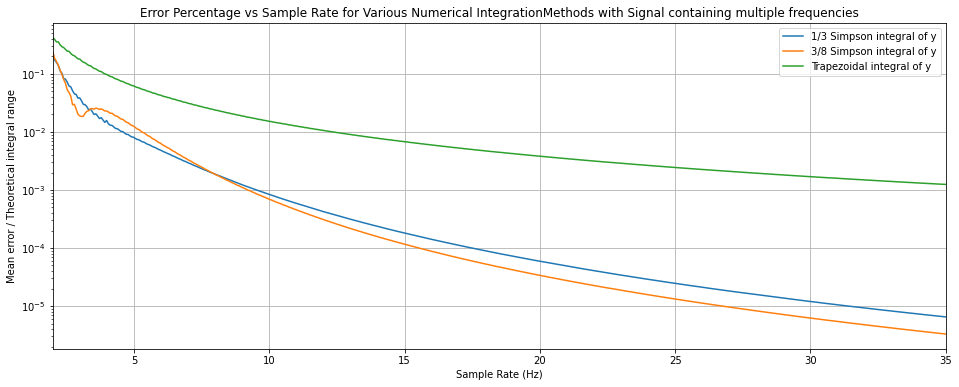

In [616]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.semilogy(sample_rate, simps_3_error2, label="1/3 Simpson integral of y")
ax.semilogy(sample_rate, simps_8_error2, label="3/8 Simpson integral of y")
ax.semilogy(sample_rate, trapz_error2, label="Trapezoidal integral of y")
ax.grid()
ax.set(xlim=(min(sample_rate), max(sample_rate)), xlabel="Sample Rate (Hz)", 
       ylabel="Mean error / Theoretical integral range", 
       title="Error Percentage vs Sample Rate for Various Numerical Integration"
       "Methods with Signal containing multiple frequencies")
ax.legend()

### Accuracy Conclusions

Observations:
- The simpson's rule implementations are all orders of magnitude more accurate than the Trapezoidal rule.
- The simpson's 1/3 rule and 3/8 rule are similar in accuracy.

The simpson's rules should be taken as the default options for autoRS. Whether to use 1/3 or 3/8 may be decided based on performance differences.

## Quantify Timing

In [484]:
def time_func(func, max_time=2, num_runs=5, func_name=None):
    cts_per_run = []
    for run in range(num_runs):
        t_ct = t0 = perf_counter()
        ct = 0
        while t_ct - t0 < max_time/num_runs:
            func()
            ct += 1
            t_ct = perf_counter()
        cts_per_run.append(ct)
    best_ct = max(cts_per_run)
    loop_time = (max_time/num_runs)/best_ct
    if func_name is not None:
        print(func_name + ":")
    print(f"{best_ct} loops in {max_time/num_runs:.3f}s, best of {num_runs}: {loop_time:.3e}s per loop")
    return loop_time

In [507]:
methods = {
    "trapezoidal": cumulative_trapezoidal,
    "1/3 simpson's rule": cumulative_integral_3,
    "3/8 simpson's rule": cumulative_integral_8,
    "scipy.integrate.cumtrapz": cumtrapz,
}

timing = [time_func(lambda: func(y(int_t), int_t, initial=0), func_name=key) for key, func in methods.items()]

trapezoidal:
23754 loops in 0.400s, best of 5: 1.684e-05s per loop
1/3 simpson's rule:
13292 loops in 0.400s, best of 5: 3.009e-05s per loop
3/8 simpson's rule:
7280 loops in 0.400s, best of 5: 5.495e-05s per loop
scipy.integrate.cumtrapz:
17279 loops in 0.400s, best of 5: 2.315e-05s per loop


[Text(0.5, 0, 'Numerical Integration method'),
 Text(0, 0.5, 'Time per loop (s)'),
 Text(0.5, 1.0, 'Timing Comparison')]

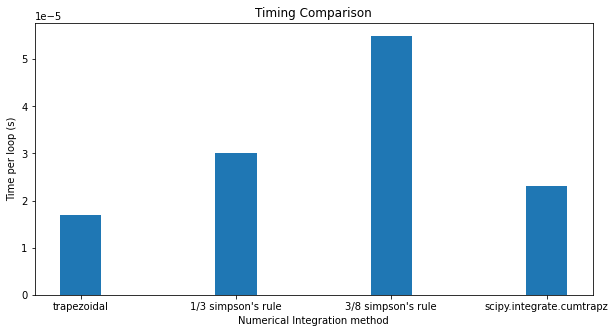

In [509]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(timing))
plt.bar(x*3, timing)
ax = plt.gca()
ax.set_xticks(x*3)
ax.set_xticklabels(methods.keys())
ax.set(
    xlabel="Numerical Integration method",
    ylabel="Time per loop (s)",
    title="Timing Comparison",
)

Custom trapezoidal integration function is the most performant. All implementations are theoretically O(n) time and space. Since the 1/3 and 3/8 simpsons rules are of similar accuracy, but the 1/3 rule is much more performant, the 1/3 rule should be the default in autoRS.

## Comparison of numpy.gradient and integration schemes

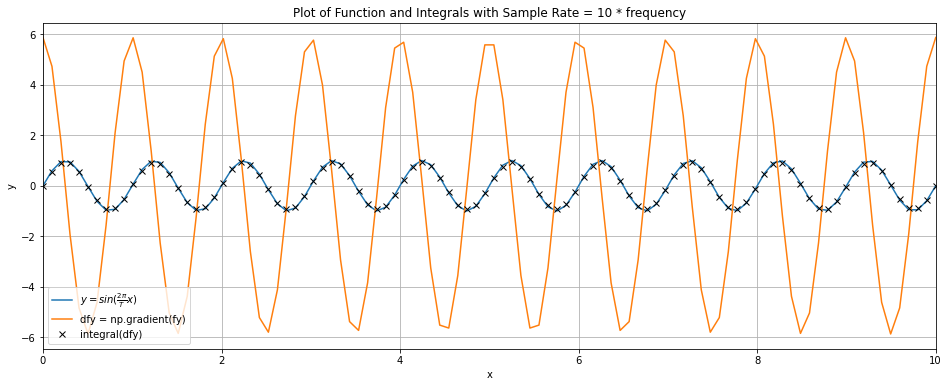

In [486]:
freq_y = 1
multiplier = 10
sample_freq_y = freq_y*multiplier
period_y = 1/freq_y

t_max = 10
t = np.linspace(0, t_max, num=100)
int_t = np.arange(0, t_max, 1/sample_freq_y)

fy = y(t)
dfy = np.gradient(fy, t)
int_dfy = cumulative_integral_8(dfy, t, initial=0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t, fy, label=r"$y=sin(\frac{2\pi}{T} x)$")
ax.plot(t, dfy, label=r"dfy = np.gradient(fy)")
ax.plot(t, int_dfy, 'kx', label="integral(dfy)")
ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Function and Integrals with Sample Rate = {multiplier} * frequency")
ax.legend(loc="lower left")
ax.grid()

In [489]:
np.max(np.abs(int_dfy - fy))/(max(fy) - min(fy))*100

3.216230861520154

In [488]:
path = os.path.join("..", "tests", "test_resources", "multi_col.csv")
df = pd.read_csv(path, header=1, dtype=float)
df = df.iloc[:, :-1]

In [559]:
time = df.values[:, 0]
acc = df.values[:, 1]

vel = cumulative_integral_3(acc, time)
disp = cumulative_integral_3(vel, time)

# vel = cumulative_trapezoidal(acc, time)
# disp = cumulative_trapezoidal(vel, time)

int_vel = np.gradient(disp, time)
int_acc = np.gradient(int_vel, time)

In [560]:
print("Maximum percentage error relative to total range of acceleration values:")
print("{:.3f}%".format(np.max(np.abs(int_acc - acc))/(max(acc) - min(acc))*100))

Maximum percentage error relative to total range of acceleration values:
0.989%


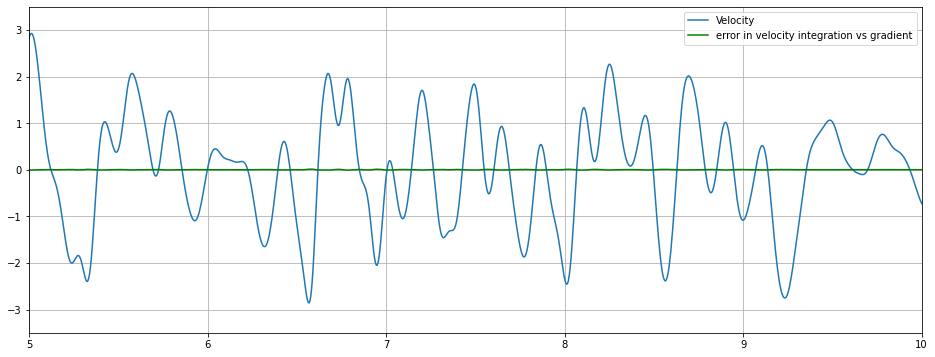

In [569]:
fig, ax = plt.subplots(figsize=(16, 6))
# ax2 = ax.twinx()
lns1 = ax.plot(time, vel, label="Velocity")
lns2 = ax.plot(time, int_vel-vel, 'g', label="error in velocity integration vs gradient")
ax.set(ylim=(-3.5, 3.5), xlim=(5, 10))
# ax2.set(ylim=(-0.1, 0.1))
plt.legend(lns1+lns2, [x.get_label() for x in lns1+lns2])
ax.grid()

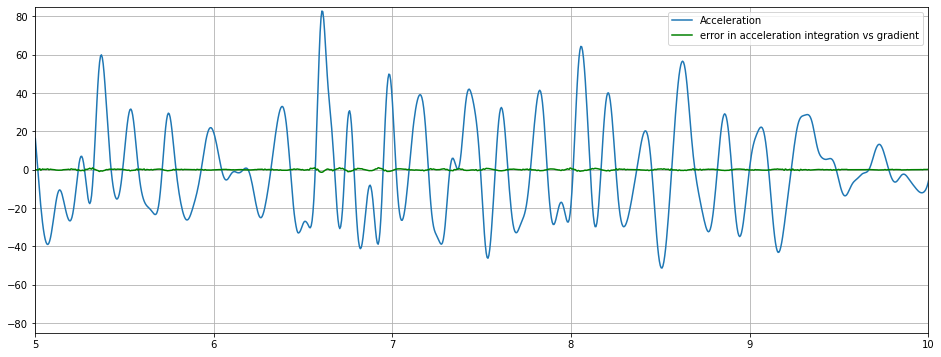

In [570]:
fig, ax = plt.subplots(figsize=(16, 6))
# ax2 = ax.twinx()
lns1 = ax.plot(time, acc, label="Acceleration")
lns2 = ax.plot(time, int_acc-acc, 'g', label="error in acceleration integration vs gradient")
ax.set(ylim=(-85, 85), xlim=(5, 10))
# ax2.set(ylim=(-85, 85))
plt.legend(lns1+lns2, [x.get_label() for x in lns1+lns2])
ax.grid()

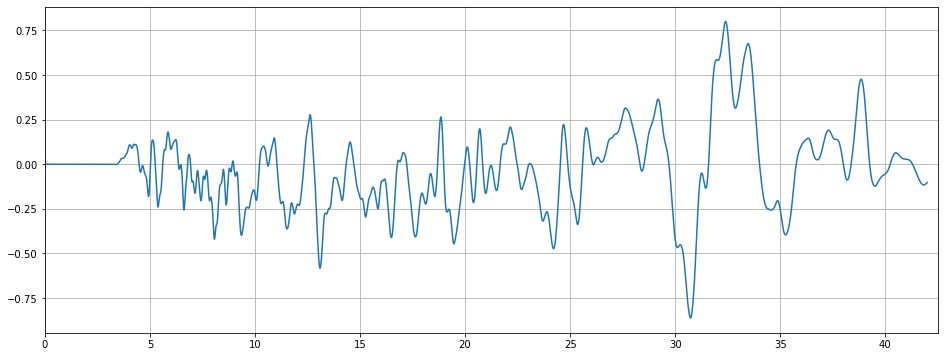

In [571]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(time, disp, '-')
ax.set(
    xlim=(0, 42.5),
#     ylim=(-0.4, 0)
)
ax.grid()